## Learning Objectives 

* Develop a function: if a block of code will be re-used several times, develop it as a function to avoid coding errors.
* ROC/AUC
* VARImp
* Train and test your model with a small dataset.
* Model with the entire dataset when there is no error.
* Keep your notebook clean and readable.
* Random forest
* Gradient boosting

In [44]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [45]:
data = pd.read_csv("//Users/Chriskuo/Downloads/XYZloan_default_selected_vars.csv")

In [46]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
     data, test_size=0.40, random_state=42)

In [47]:
train.shape

(48000, 89)

In [48]:
var = pd.DataFrame(train.dtypes)
var.head(10)

,0
Unnamed: 0,int64
Unnamed: 0.1,int64
id,int64
loan_default,int64
AP001,int64
AP002,int64
AP003,int64
AP004,int64
AP005,object
AP006,object


In [49]:
var = pd.DataFrame(train.dtypes).reset_index()
var.head()

,index,0
0,Unnamed: 0,int64
1,Unnamed: 0.1,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [50]:
var.columns = ['varname','dtype'] 
var.head()

,varname,dtype
0,Unnamed: 0,int64
1,Unnamed: 0.1,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [51]:
var['source'] = var['varname'].str[:2]
var.head()

,varname,dtype,source
0,Unnamed: 0,int64,Un
1,Unnamed: 0.1,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP


In [52]:
var['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
Un     2
MB     2
lo     1
id     1
Name: source, dtype: int64

In [53]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [54]:
train['loan_default'].value_counts(dropna=False)

0    38736
1     9264
Name: loan_default, dtype: int64

# H2O

* If you encounter errors, [this page](https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/index.html) may help.

In [55]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_151"; Java(TM) SE Runtime Environment (build 1.8.0_151-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.151-b12, mixed mode)
  Starting server from /Users/chriskuo/anaconda3/envs/AD/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/jw/wyhtzlf94zbgtpf9g_n5tryr0000gn/T/tmpssf506ho
  JVM stdout: /var/folders/jw/wyhtzlf94zbgtpf9g_n5tryr0000gn/T/tmpssf506ho/h2o_chriskuo_started_from_python.out
  JVM stderr: /var/folders/jw/wyhtzlf94zbgtpf9g_n5tryr0000gn/T/tmpssf506ho/h2o_chriskuo_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,4 months and 23 days !!!
H2O cluster name:,H2O_from_python_chriskuo_y8dmvx
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [56]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [57]:
target='loan_default'

### When you model, you should run with a small sample dataset

* Try to write repeating code in a function

In [58]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [59]:
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

In [60]:
rf_v1 = H2ORandomForestEstimator(
        model_id = 'rf_v1',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v1.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |███████████████████████████████████████████████| 100%


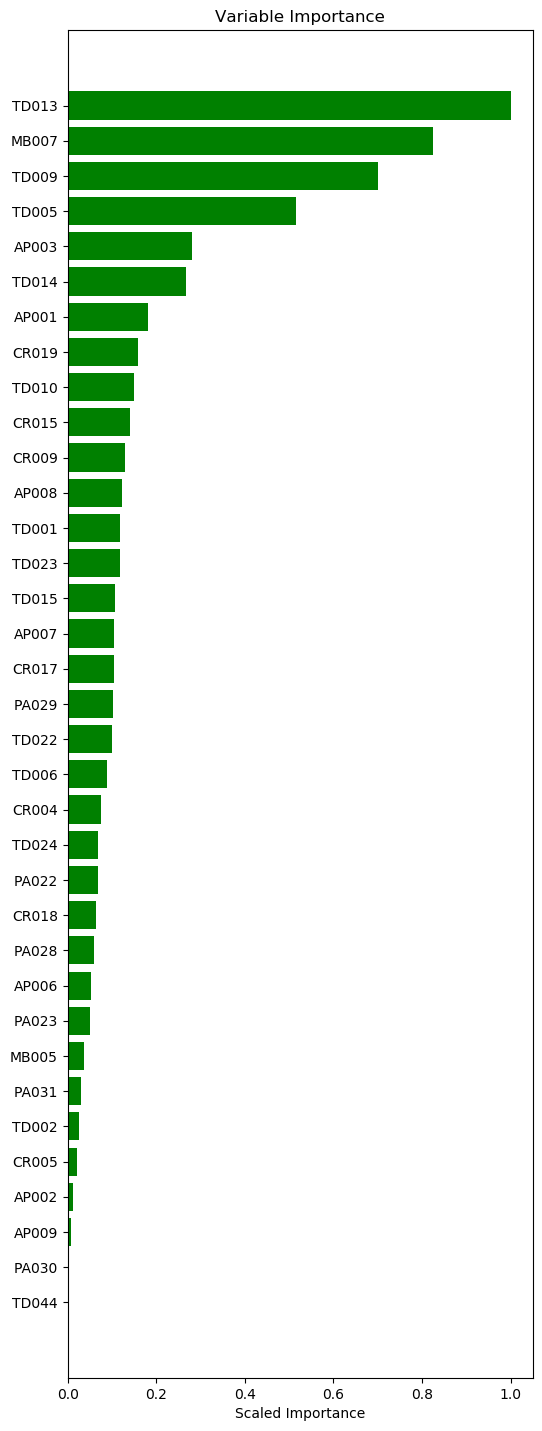

In [61]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()
    
VarImp(rf_v1)

In [62]:
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(rf_v1)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,100,220,320,100,220,0.17,0.08,60.0,1.67,9.0,31.25
1,320,83,237,640,183,457,0.30,0.18,120.0,1.52,12.0,28.59
2,320,84,236,960,267,693,0.44,0.27,180.0,1.48,17.0,27.81
3,320,58,262,1280,325,955,0.54,0.37,240.0,1.35,17.0,25.39
4,320,70,250,1600,395,1205,0.66,0.46,300.0,1.32,20.0,24.69
5,320,48,272,1920,443,1477,0.74,0.57,360.0,1.23,17.0,23.07
6,320,42,278,2240,485,1755,0.81,0.68,420.0,1.15,13.0,21.65
7,320,51,269,2560,536,2024,0.89,0.78,480.0,1.12,11.0,20.94
8,320,41,279,2880,577,2303,0.96,0.89,540.0,1.07,7.0,20.03


In [63]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



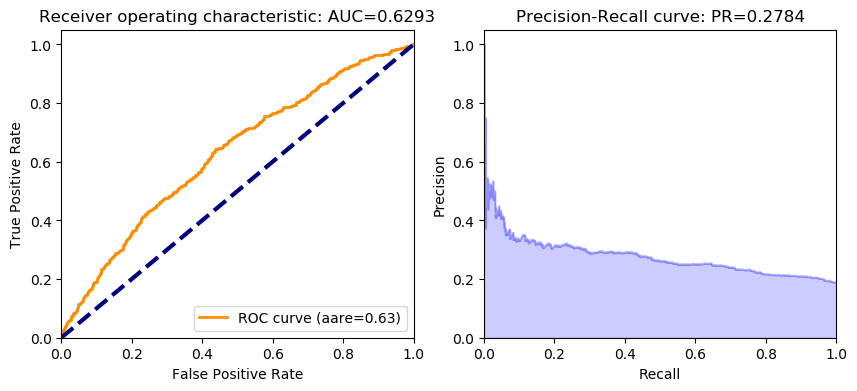

In [64]:
ROC_AUC(rf_v1,test_hex,'loan_default')

### Now the code works fine with the small dataset, we can model with the entire dataset

In [65]:
rf_v2 = H2ORandomForestEstimator(
        model_id = 'rf_v2',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v2.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [66]:
createGains(rf_v2)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,100,220,320,100,220,0.17,0.08,60.0,1.67,9.0,31.25
1,320,83,237,640,183,457,0.30,0.18,120.0,1.52,12.0,28.59
2,320,84,236,960,267,693,0.44,0.27,180.0,1.48,17.0,27.81
3,320,58,262,1280,325,955,0.54,0.37,240.0,1.35,17.0,25.39
4,320,70,250,1600,395,1205,0.66,0.46,300.0,1.32,20.0,24.69
5,320,48,272,1920,443,1477,0.74,0.57,360.0,1.23,17.0,23.07
6,320,42,278,2240,485,1755,0.81,0.68,420.0,1.15,13.0,21.65
7,320,51,269,2560,536,2024,0.89,0.78,480.0,1.12,11.0,20.94
8,320,41,279,2880,577,2303,0.96,0.89,540.0,1.07,7.0,20.03


### GBM

In [67]:
gbm_v1 = H2OGradientBoostingEstimator(
        model_id = 'gbm_v1',
        seed=1234)
gbm_v1.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


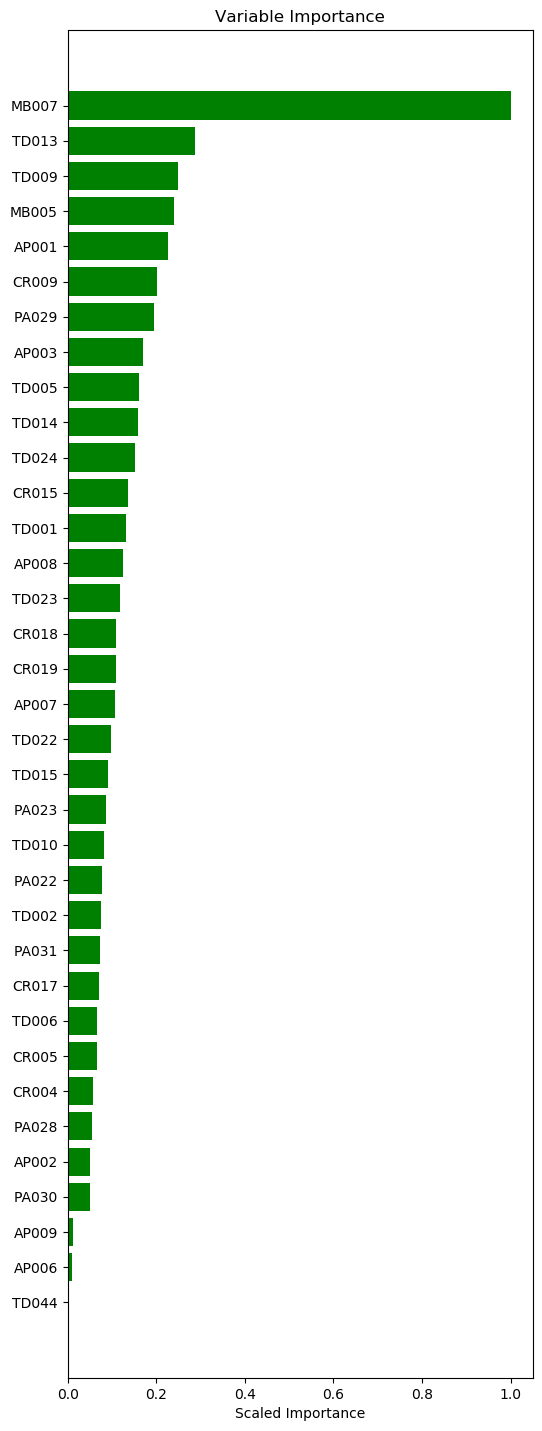

In [68]:
VarImp(gbm_v1)

In [69]:
createGains(gbm_v1)

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,95,225,320,95,225,0.16,0.09,60.0,1.58,7.0,29.69
1,320,82,238,640,177,463,0.30,0.18,120.0,1.48,12.0,27.66
2,320,67,253,960,244,716,0.41,0.28,180.0,1.36,13.0,25.42
3,320,67,253,1280,311,969,0.52,0.37,240.0,1.30,15.0,24.30
4,320,64,256,1600,375,1225,0.62,0.47,300.0,1.25,15.0,23.44
5,320,59,261,1920,434,1486,0.72,0.57,360.0,1.21,15.0,22.60
6,320,57,263,2240,491,1749,0.82,0.67,420.0,1.17,15.0,21.92
7,320,45,275,2560,536,2024,0.89,0.78,480.0,1.12,11.0,20.94
8,320,27,293,2880,563,2317,0.94,0.89,540.0,1.04,5.0,19.55


gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



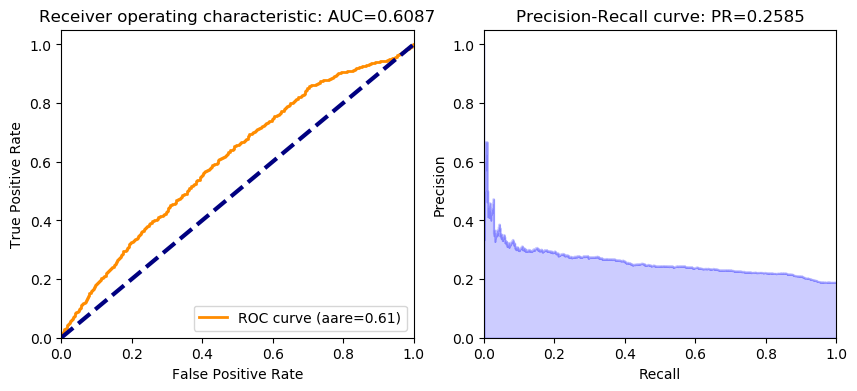

In [70]:
ROC_AUC(gbm_v1,test_hex,'loan_default')

In [ ]:
#modelfile = rf_v2.download_mojo('rf_v1_mojo',get_genmodel_har=True)
#model_path = h2o.save_model('rf_v1',force=True)